# Introducción

En esta libreta de Jupyter se encuentra desglosado en código todo lo realizado y presentado para el trabajo escrito. Se respeta la enumeración que se lleva en el documento escrito.

# 0. Código 

Esta sección contiene las diferentes funciones y código que se usará a lo largo del proyecto

In [1]:
# Importar librerías

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
def Plot_DistributionMacronutrients(Diets_Dataset:pd.DataFrame,Macronutrients:list[str]) -> None:
    """
        Función para gráficar los gráficos de tipo cajas y bigotes 
        por cada macronutriente.
    """
    Display = "PPCC\n.FF."
    fig , axes = plt.subplot_mosaic(Display,figsize=(12,8),layout='tight')

    ConfigPlot = zip(Macronutrients,['C','P','F'],['green','red','yellow'])
    for macronutrient , display , color in ConfigPlot:
        sns.boxplot(data=Diets_Dataset,x=macronutrient,ax=axes[display],color=color)
        axes[display].set_title(macronutrient[:-3])
        axes[display].set_xlabel('Grams')

    fig.suptitle('Distribución de Macronutrientes',size=20)

## Carga de Datos

In [ ]:
# Carga de datos

Diets_Dataset = pd.read_csv('./Diets_Dataset.csv')
Diets_Dataset.drop(columns=['Extraction_day','Extraction_time'],inplace=True)

In [3]:
# Definición de variables principales

Macronutrients = ['Carbs(g)','Protein(g)','Fat(g)']
Diets = ['dash', 'keto', 'mediterranean', 'paleo', 'vegan']

# 1. Presentación de los Datos

## 1.3 Variables del Conjunto de Datos

In [18]:
Diets

['dash', 'keto', 'mediterranean', 'paleo', 'vegan']

In [ ]:
# Ejemplos de registros del conjunto de datos

Diets_Dataset

,Diet_type,Recipe_name,Cuisine_type,Protein(g),Carbs(g),Fat(g)
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55
...,...,...,...,...,...,...
7801,dash,Brown Butter-Sunchoke Soup With Brussels Sprou...,italian,85.20,288.14,137.15
7802,dash,Make-Your-Own-Salad,american,141.98,123.18,323.50
7803,dash,Luis Buñuel Dry Martini,world,0.01,0.39,0.00
7804,dash,Cornflake Semi-Fried Chicken Tenders,american,155.38,239.88,260.84


In [7]:
# Valore únicos por variable en el conjunto de datos

Diets_Dataset.apply(lambda column: len(pd.Series.unique(column)),axis=0)

Diet_type          5
Recipe_name     7062
Cuisine_type      19
Protein(g)      6060
Carbs(g)        6618
Fat(g)          6322
dtype: int64

# 2. Estadística Descriptiva

## 2.0 Transformación de los Macronutrientes a Valores Proporcionales 

Como se mencionó en el documento escrito, de cada receta, los valores de sus aportes nutricionales son normalizados usando el total de macronutrientes que aporta cada receta.

In [8]:
# Total de macronutrientes por receta

Diets_Dataset['Total_Macronutrients'] = Diets_Dataset[Macronutrients].apply(sum,axis=1)

In [16]:
# Normalización de cada valor de macronutriente

for macronutrient in Macronutrients:
    Diets_Dataset[macronutrient] /= Diets_Dataset['Total_Macronutrients']

## 2.1 Medidas de Tendencia Central y Dispersión

In [130]:
# Calculo de las medidas de tendencia central, dispersión y asimetría 

summary_measures = Diets_Dataset[Macronutrients].describe().loc[['mean','25%','50%','75%','std','min','max']]
summary_measures.loc['skewness'] = Diets_Dataset[Macronutrients].skew()

summary_measures

,Carbs(g),Protein(g),Fat(g)
mean,0.433471,0.234762,0.331767
25%,0.205251,0.110188,0.184583
50%,0.432028,0.190931,0.314359
75%,0.635058,0.338059,0.464532
std,0.256032,0.163886,0.194920
min,0.000330,0.000000,0.000000
max,1.000000,0.887557,0.997940
skewness,0.189556,0.922401,0.461455


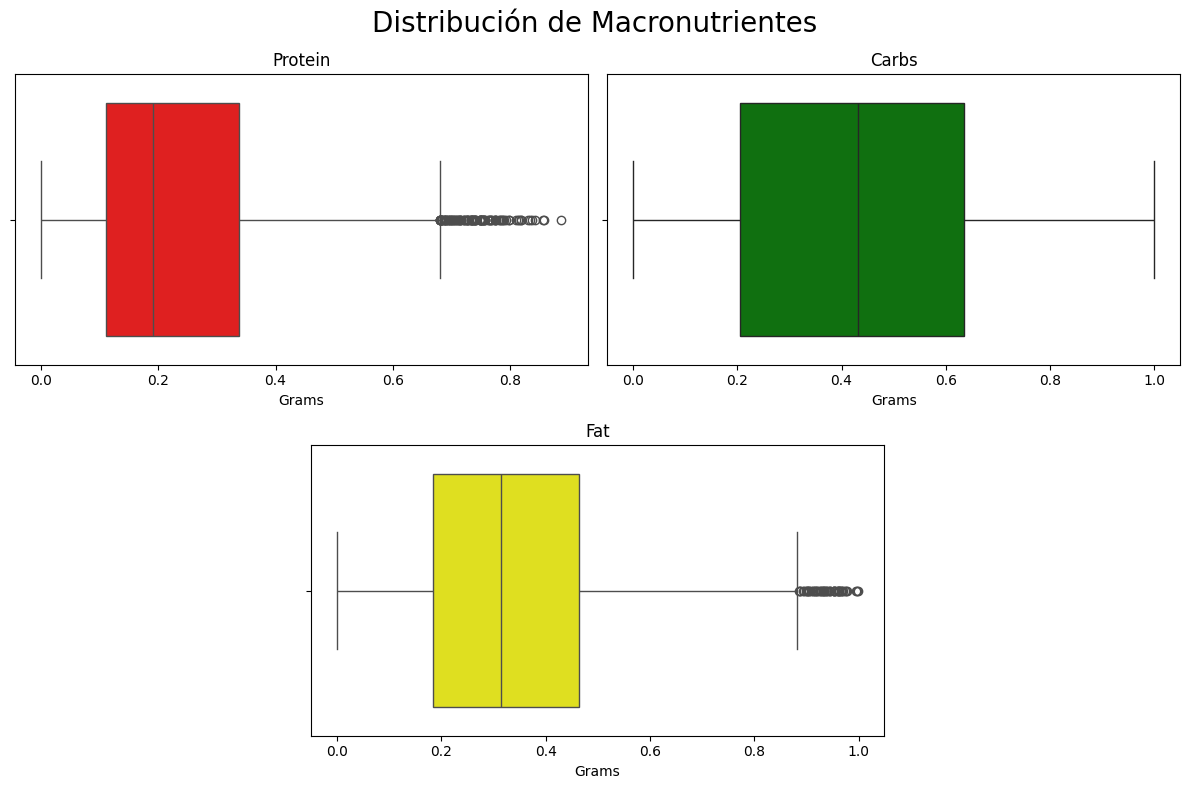

In [ ]:
# Plot de la distribución de los macronutrientes

Plot_DistributionMacronutrients(Diets_Dataset,Macronutrients)